In [1]:
from matplotlib import pyplot as plt, style
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from datetime import datetime, timedelta
from lxml import html, etree, objectify
from collections import defaultdict
import pandas as pd
import requests
import csv
import re

DATE_FM = "%Y-%m-%d"
style.use('ggplot')

In [2]:
# getting html tree from the url
domen = "https://www.sec.gov"
start_url = "/cgi-bin/browse-edgar?action=getcompany&CIK=0001656456&owner=exclude&count=40&hidefilings=0"
page = requests.get(domen + start_url)
tree = html.fromstring(page.content)
table = tree.find('.//div[@id="seriesDiv"]')

detail_page_links = []
for row in table.findall('.//tr'):
    link_cell, title_cell = row[1:3]
    if link_cell.tag == "td":  # not a header element th
        if title_cell.text is not None and title_cell.text.startswith("Quarterly report"):
            detail_page_links.append(link_cell[0].get('href'))

detail_page_links

['/Archives/edgar/data/1656456/000165645618000003/0001656456-18-000003-index.htm',
 '/Archives/edgar/data/1656456/000165645617000005/0001656456-17-000005-index.htm',
 '/Archives/edgar/data/1656456/000165645617000004/0001656456-17-000004-index.htm',
 '/Archives/edgar/data/1656456/000165645617000003/0001656456-17-000003-index.htm',
 '/Archives/edgar/data/1656456/000165645617000002/0001656456-17-000002-index.htm',
 '/Archives/edgar/data/1656456/000165645616000010/0001656456-16-000010-index.htm',
 '/Archives/edgar/data/1656456/000165645616000008/0001656456-16-000008-index.htm',
 '/Archives/edgar/data/1656456/000165645616000007/0001656456-16-000007-index.htm']

In [3]:
detail_page_links = detail_page_links[:4]  # we get only 4 latest reports

file_links = []
for detail_url in detail_page_links:
    page = requests.get(domen + detail_url)
    tree = html.fromstring(page.content)
    table = tree.find('.//table[@class="tableFile"]')
    
    for row in table.findall('.//tr'):
        doc_cell, type_cell = row[2:4]
        
        if type_cell.text == "INFORMATION TABLE":
            link = doc_cell[0]            
            if link.text.endswith(".xml"):
                file_link = doc_cell[0].get("href")
                
                period_header = tree.xpath('.//div[text()="Period of Report"]')[0]
                period_container = period_header.getnext()
                report_date = period_container.text
                
                file_links.append((file_link, report_date))
                
file_links

[('/Archives/edgar/data/1656456/000165645618000003/Form13FInfoTable.xml',
  '2017-12-31'),
 ('/Archives/edgar/data/1656456/000165645617000005/Form13FInfoTable.xml',
  '2017-09-30'),
 ('/Archives/edgar/data/1656456/000165645617000004/Form13FInfoTable.xml',
  '2017-06-30'),
 ('/Archives/edgar/data/1656456/000165645617000003/Form13FInfoTable.xml',
  '2017-03-31')]

In [4]:
report_dates = list(sorted(datetime.strptime(s, DATE_FM) for _, s in file_links))
report_dates

[datetime.datetime(2017, 3, 31, 0, 0),
 datetime.datetime(2017, 6, 30, 0, 0),
 datetime.datetime(2017, 9, 30, 0, 0),
 datetime.datetime(2017, 12, 31, 0, 0)]

In [5]:
data = []
for link, report_date in file_links:
    page = requests.get(domen + link)
    table = objectify.fromstring(page.content)
    
    for row in table.infoTable:
        if row.shrsOrPrnAmt.sshPrnamtType.text == "SH":
            data.append((row.nameOfIssuer.text, report_date, row.shrsOrPrnAmt.sshPrnamt.text))

shares = pd.DataFrame.from_records(sorted(data), columns=("Name", "Date", "Value"))
shares[15:30]

,Name,Date,Value
15,ALLY FINL INC,2017-06-30,1097824
16,ALLY FINL INC,2017-09-30,6810600
17,ALLY FINL INC,2017-12-31,8036523
18,ALPHABET INC,2017-03-31,475000
19,ALPHABET INC,2017-06-30,585000
20,ALPHABET INC,2017-09-30,568000
21,ALPHABET INC,2017-12-31,355729
22,ALPS ETF TR,2017-03-31,2108582
23,ALTABA INC,2017-06-30,5129051
24,ALTABA INC,2017-09-30,4682500


In [6]:
symbols = []
with open("nasdaqtraded.txt") as f:
    reader = csv.reader(f, delimiter='|', quotechar='"')
    for row in list(reader)[1:]:
        symbol, name = row[1:3]
        name = re.sub(r"[^\w ]", "", name).upper()
        symbols.append((name, symbol))
symbols[:20]

[('AGILENT TECHNOLOGIES INC COMMON STOCK', 'A'),
 ('ALCOA CORPORATION COMMON STOCK ', 'AA'),
 ('ADVANCED ACCELERATOR APPLICATIONS SA  AMERICAN DEPOSITARY SHARES', 'AAAP'),
 ('ALTABA INC  COMMON STOCK', 'AABA'),
 ('AAC HOLDINGS INC COMMON STOCK', 'AAC'),
 ('ADVISORSHARES DORSEY WRIGHT ADR ETF', 'AADR'),
 ('AMERICAN AIRLINES GROUP INC  COMMON STOCK', 'AAL'),
 ('ALTISOURCE ASSET MANAGEMENT CORP COM', 'AAMC'),
 ('ATLANTIC AMERICAN CORPORATION  COMMON STOCK', 'AAME'),
 ('AARONS INC COMMON STOCK', 'AAN'),
 ('APPLIED OPTOELECTRONICS INC  COMMON STOCK', 'AAOI'),
 ('AAON INC  COMMON STOCK', 'AAON'),
 ('ADVANCE AUTO PARTS INC ADVANCE AUTO PARTS INC WI', 'AAP'),
 ('APPLE INC  COMMON STOCK', 'AAPL'),
 ('AMERICAN ASSETS TRUST INC COMMON STOCK', 'AAT'),
 ('ALMADEN MINERALS LTD COMMON SHARES', 'AAU'),
 ('ADVANTAGE OIL  GAS LTD  ORDINARY SHARES', 'AAV'),
 ('ATLAS AIR WORLDWIDE HOLDINGS  COMMON STOCK', 'AAWW'),
 ('ISHARES MSCI ALL COUNTRY ASIA EX JAPAN INDEX FUND', 'AAXJ'),
 ('AXON ENTERPRISE INC  COMM

In [7]:
def resolve_symbol(name):
    # 
    hardcoded_symbols = {
        "ARCELORMITTAL SA LUXEMBOURG": "MT",
        "GOODYEAR TIRE & RUBR CO": "GT",
        "HAIN CELESTIAL GROUP INC": "HAIN",
        "PENNEY J C INC": "JCP",
    }
    if name in hardcoded_symbols:
        return hardcoded_symbols[name]
    
    # looking for a whole name occurrence at first
    name_parts = name.split()    
    while name_parts:   
        name = " ".join(name_parts)
        for n, s in symbols:
            if n.startswith(name):
                return s     
            
        # then remove the last word, until we either find or run out of words
        name_parts = name_parts[:-1]

resolve_symbol("APPLE INC")

'AAPL'

In [8]:
def get_price_data(symbol, start, end): 
    url = "https://query1.finance.yahoo.com/v7/finance/chart/{}?period1={:.0f}&period2={:.0f}"\
          "&interval=1d&indicators=quote&includeTimestamps=true&"\
          "events=div%7Csplit%7Cearn".format(symbol, start.timestamp(), end.timestamp())
            
    page = requests.get(url)
    result = page.json()['chart']['result']
    if not result:
        print(symbol, page.json())
        return
    
    data = result[0]
    quote = data['indicators']['quote'][0]
    if 'timestamp' not in data:
        return
    
    result = dict(
        index=[datetime.fromtimestamp(t) for t in data['timestamp']],
        close=quote["close"],
    )           
    return result

price_data = get_price_data("AAPL", datetime(2016, 10, 1), datetime(2017, 7, 1))
price_data

{'close': [112.5199966430664,
  113.0,
  113.05000305175781,
  113.88999938964844,
  114.05999755859375,
  116.05000305175781,
  116.30000305175781,
  117.33999633789062,
  116.9800033569336,
  117.62999725341797,
  117.55000305175781,
  117.47000122070312,
  117.12000274658203,
  117.05999755859375,
  116.5999984741211,
  117.6500015258789,
  118.25,
  115.58999633789062,
  114.4800033569336,
  113.72000122070312,
  113.54000091552734,
  111.48999786376953,
  111.58999633789062,
  109.83000183105469,
  108.83999633789062,
  110.41000366210938,
  111.05999755859375,
  110.87999725341797,
  107.79000091552734,
  108.43000030517578,
  105.70999908447266,
  107.11000061035156,
  109.98999786376953,
  109.94999694824219,
  110.05999755859375,
  111.7300033569336,
  111.80000305175781,
  111.2300033569336,
  111.79000091552734,
  111.56999969482422,
  111.45999908447266,
  110.5199966430664,
  109.48999786376953,
  109.9000015258789,
  109.11000061035156,
  109.94999694824219,
  111.0299987

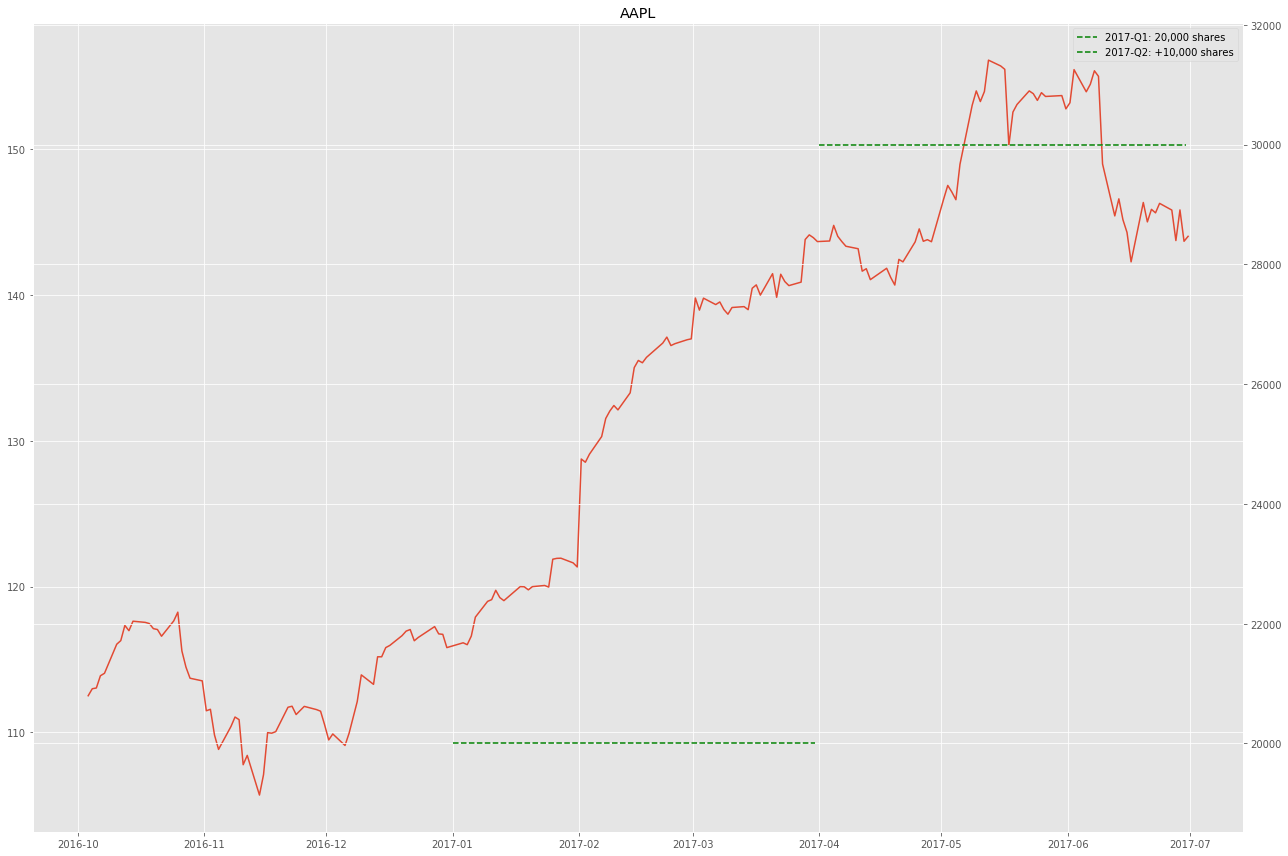

In [9]:
months = MonthLocator(range(1, 13), bymonthday=1, interval=3)
monthsFmt = DateFormatter("%b '%y")

def plot_data(symbol, p_data, s_data):
    fig = plt.figure(figsize=(18, 12)) 
    ax1 = plt.subplot(111)
    ax1.set_title(symbol)
    ax1.plot(p_data["index"], p_data["close"], label='Price')    
    
    ax1.xaxis.set_major_locator(months)
    ax1.xaxis.set_major_formatter(monthsFmt)
    
    ax2 = ax1.twinx()
    for line in s_data:
        start, end, value, change = line
        value_str = "{:+,}".format(change) if change is not None else "{:,}".format(value)
        ax2.plot([start, end], [value, value], "g--", 
                 label='{}-Q{}: {} shares'.format(start.year, start.month // 3 + 1, value_str))
    bottom, top = ax2.axes.get_ylim()
    ax2.axes.set_ylim(bottom * 0.95, top * 1.05)
    fig.tight_layout()
    plt.legend(loc='best')
    plt.show()

shares_data = [
    (datetime(2017, 1, 1), datetime(2017, 3, 31), 20000, None),
    (datetime(2017, 4, 1), datetime(2017, 6, 30), 30000, 10000)
]
plot_data("AAPL", price_data, shares_data)

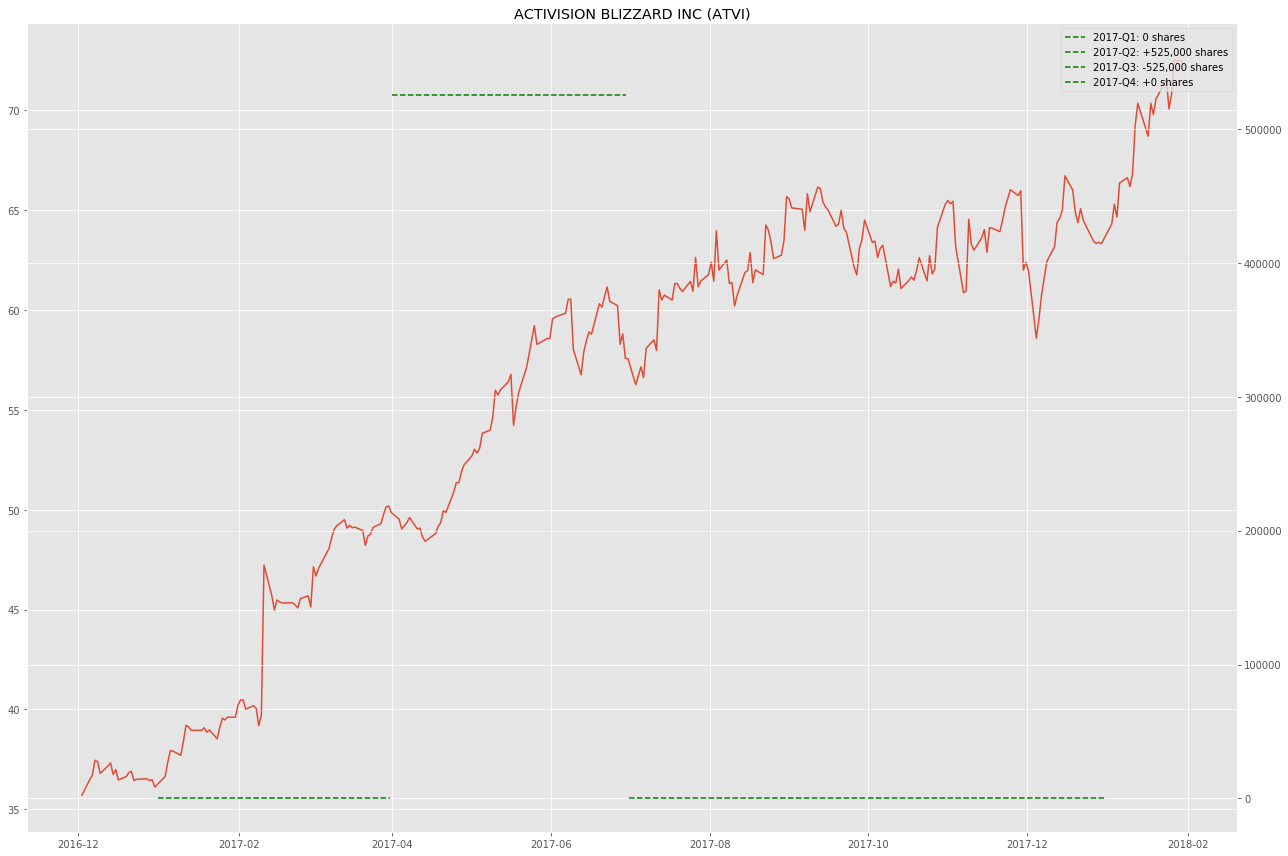

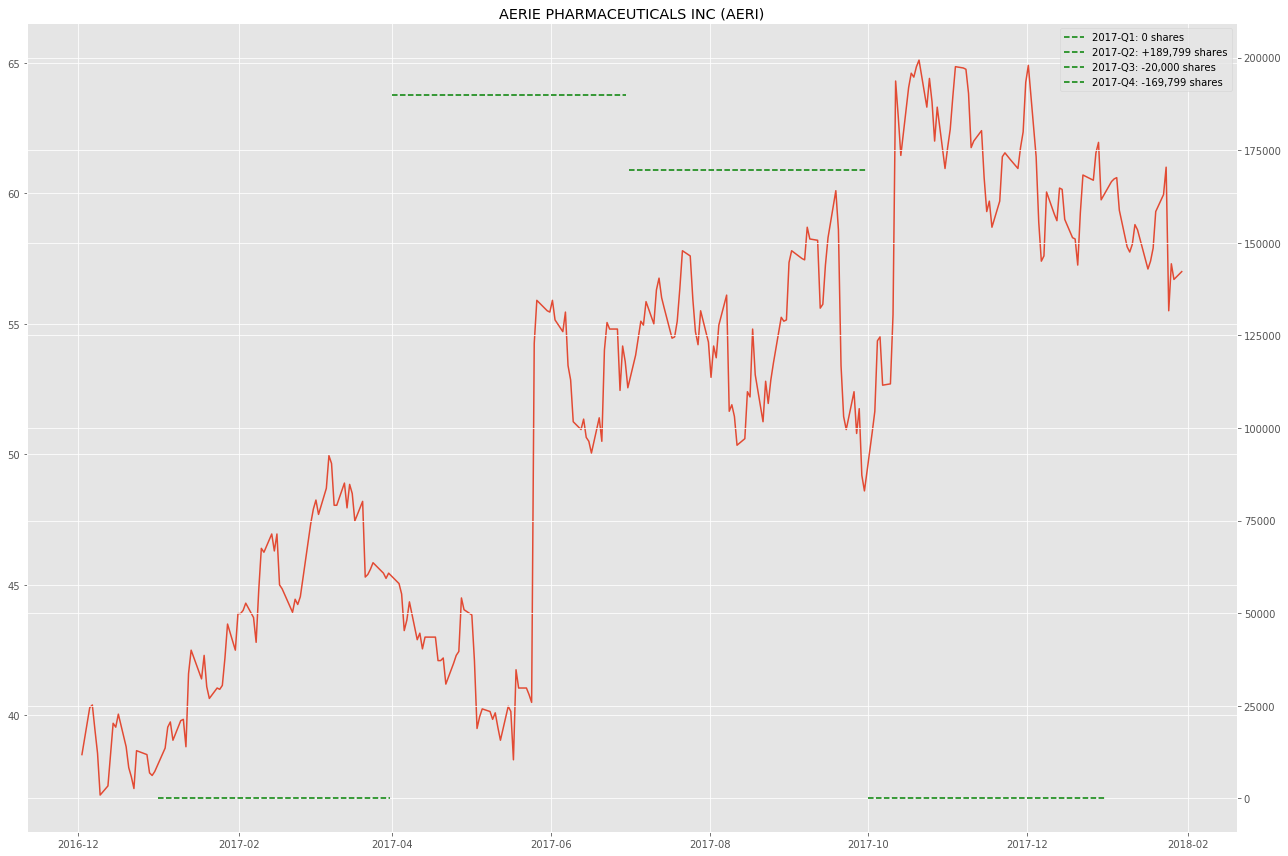

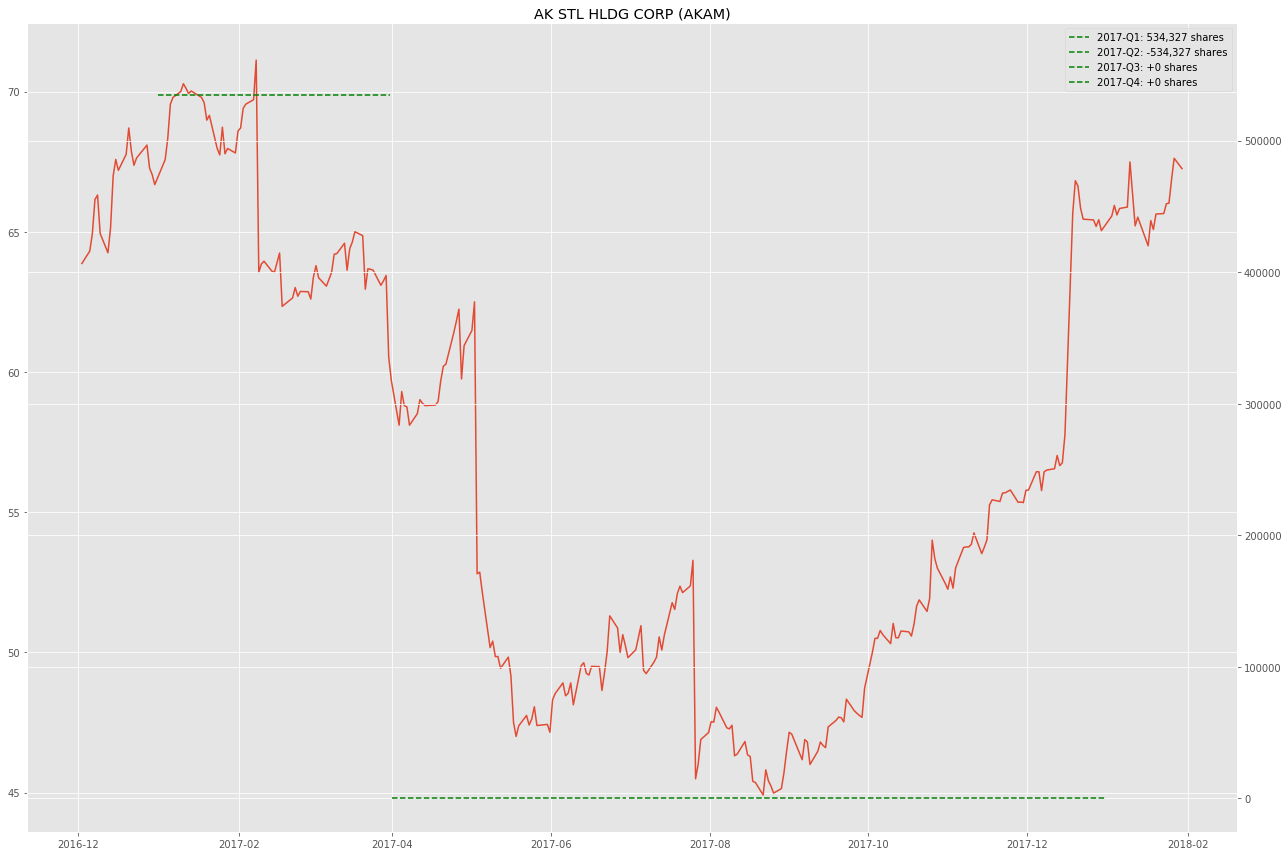

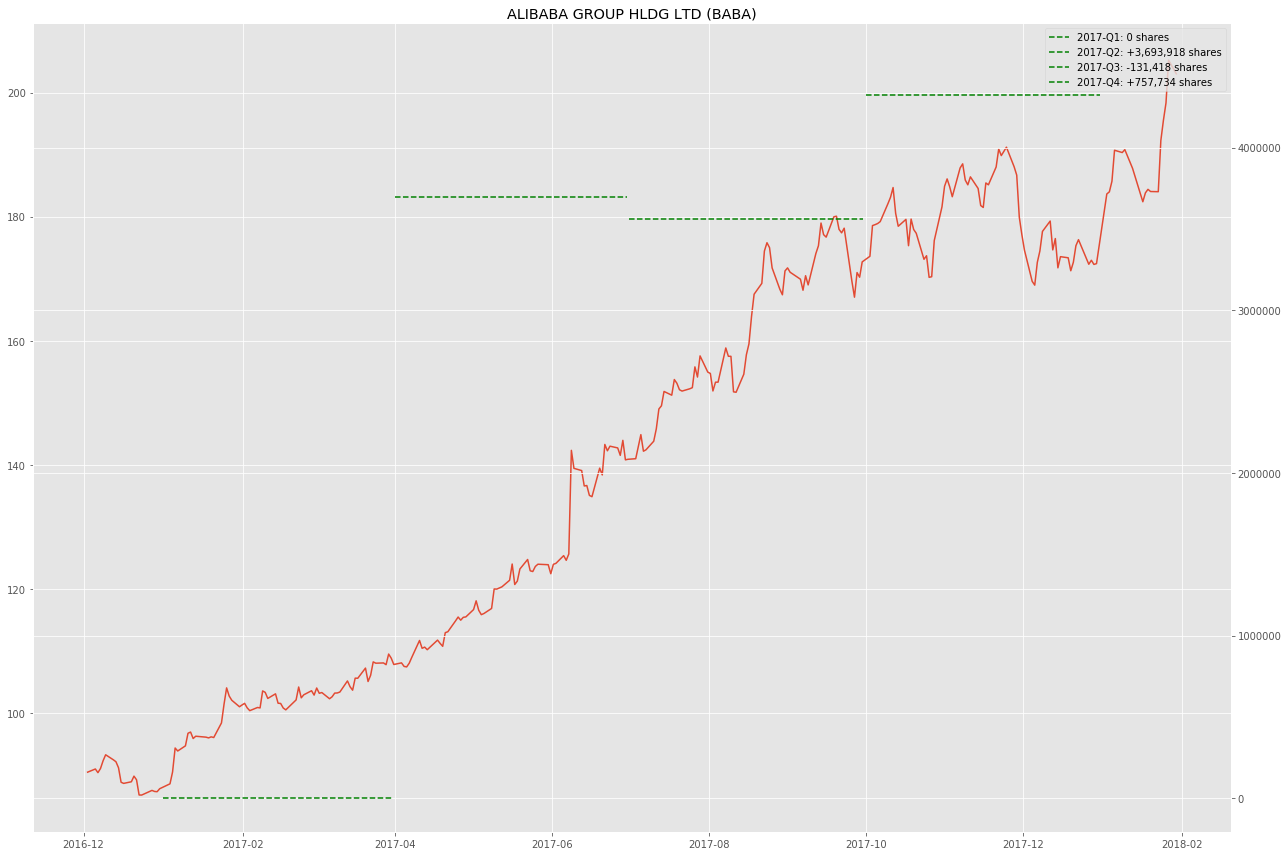

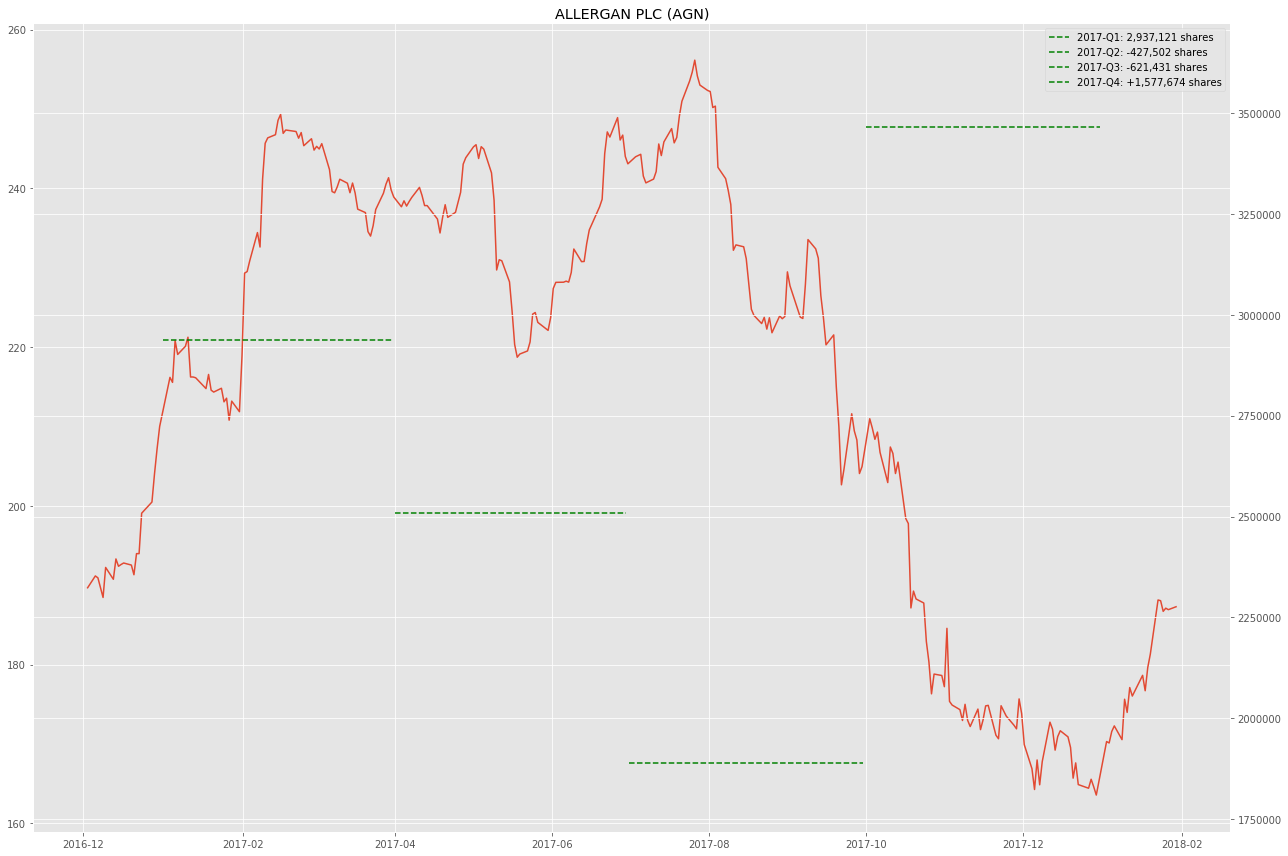

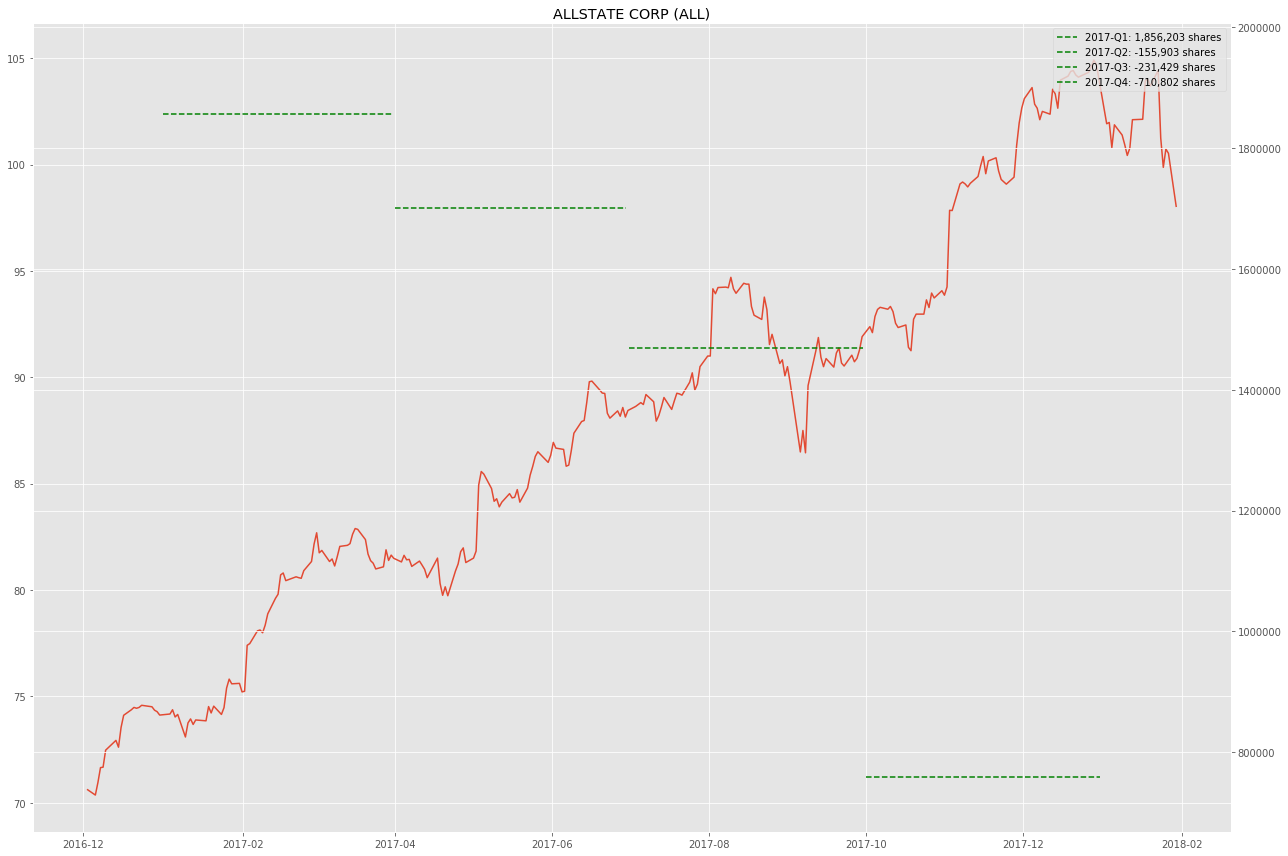

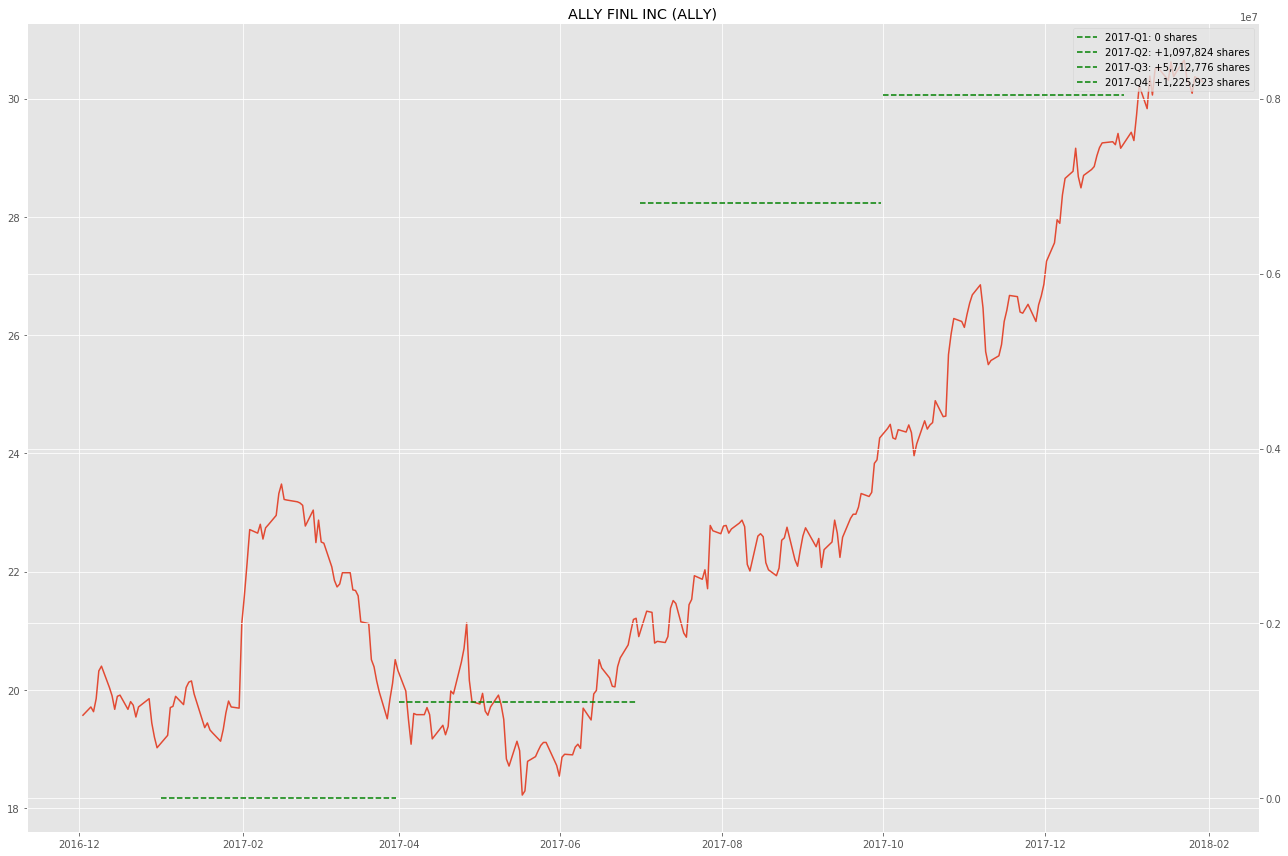

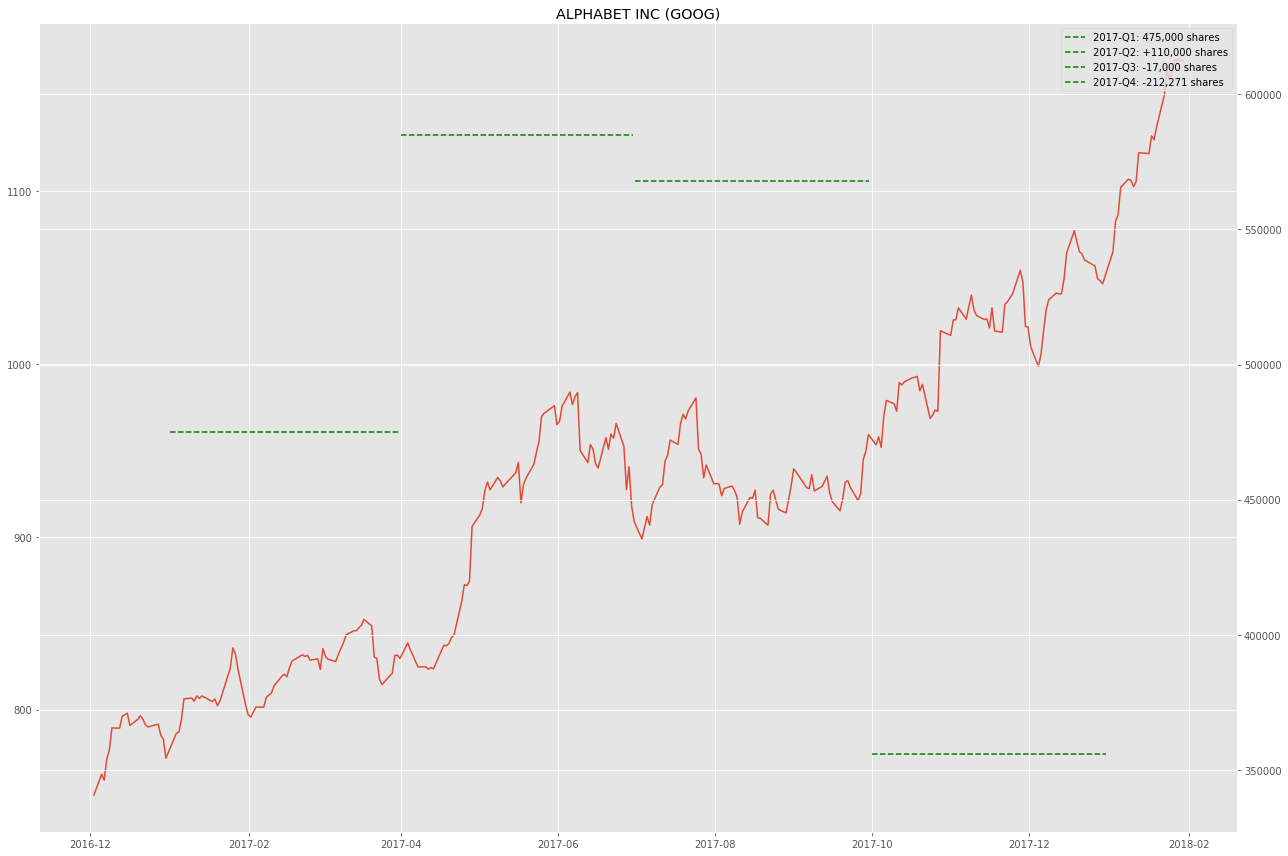

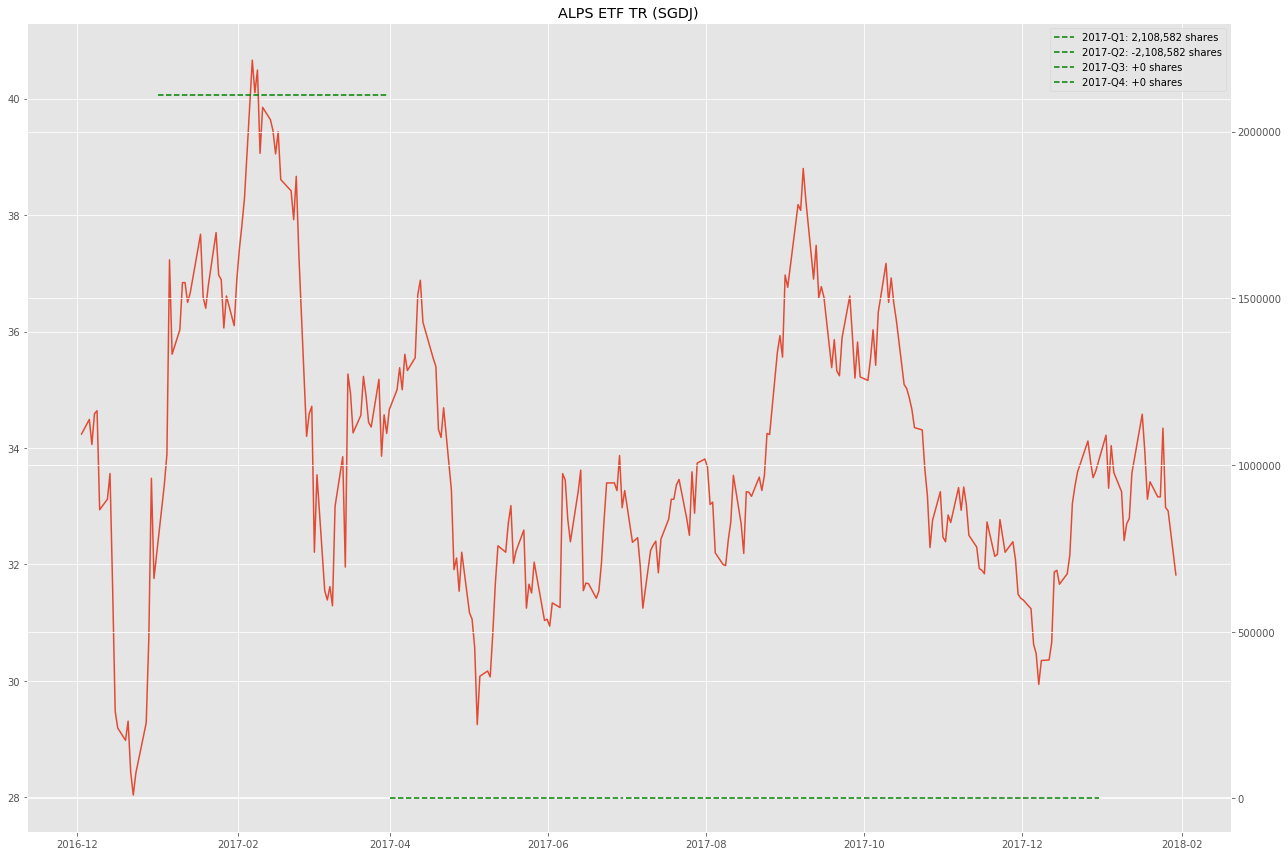

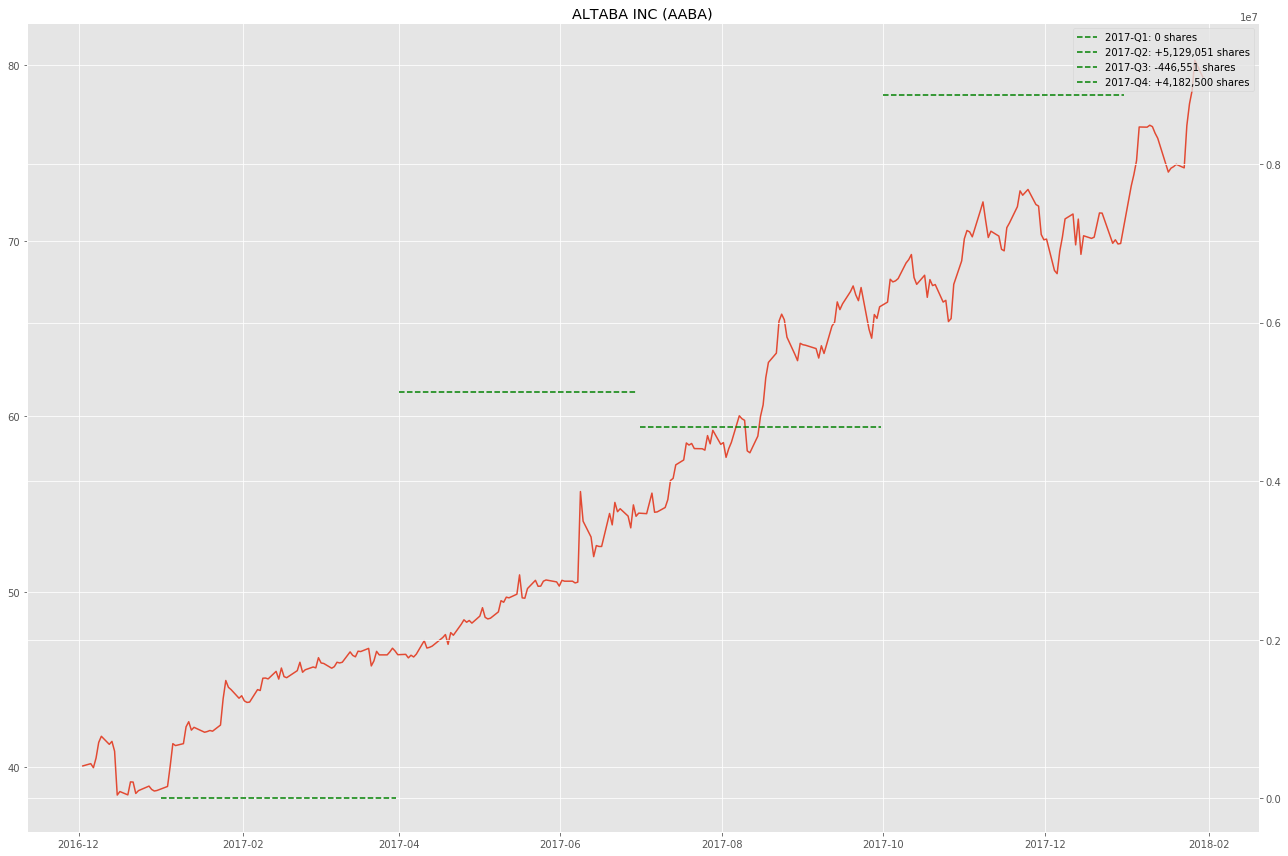

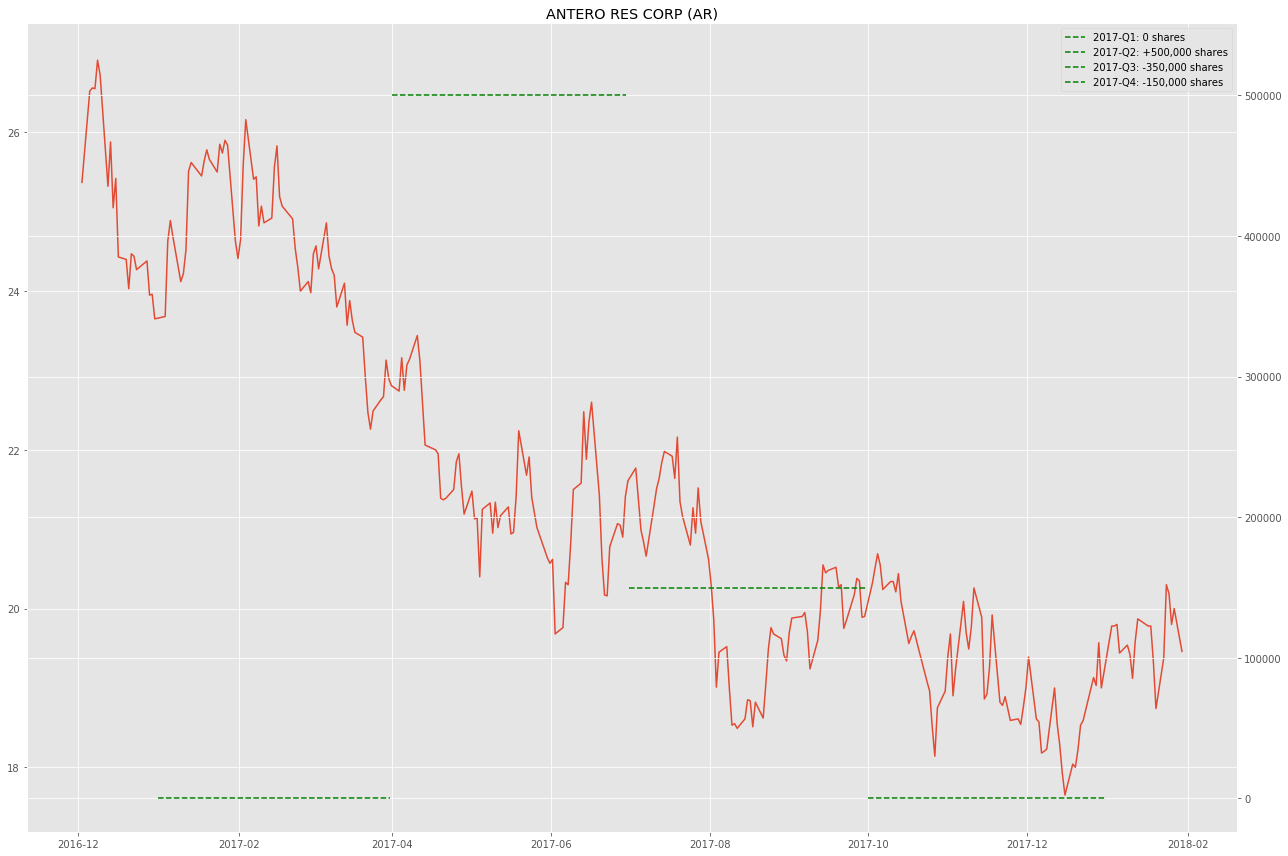

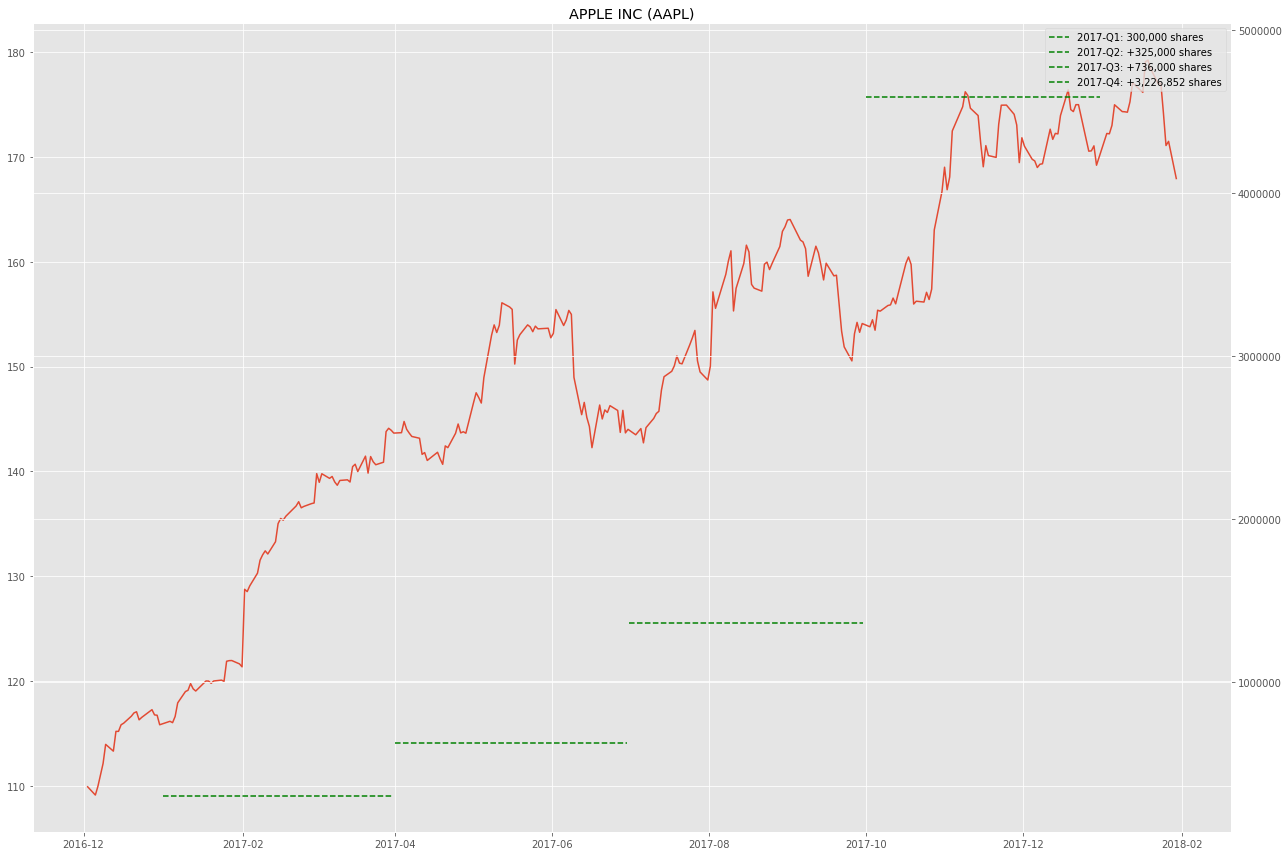

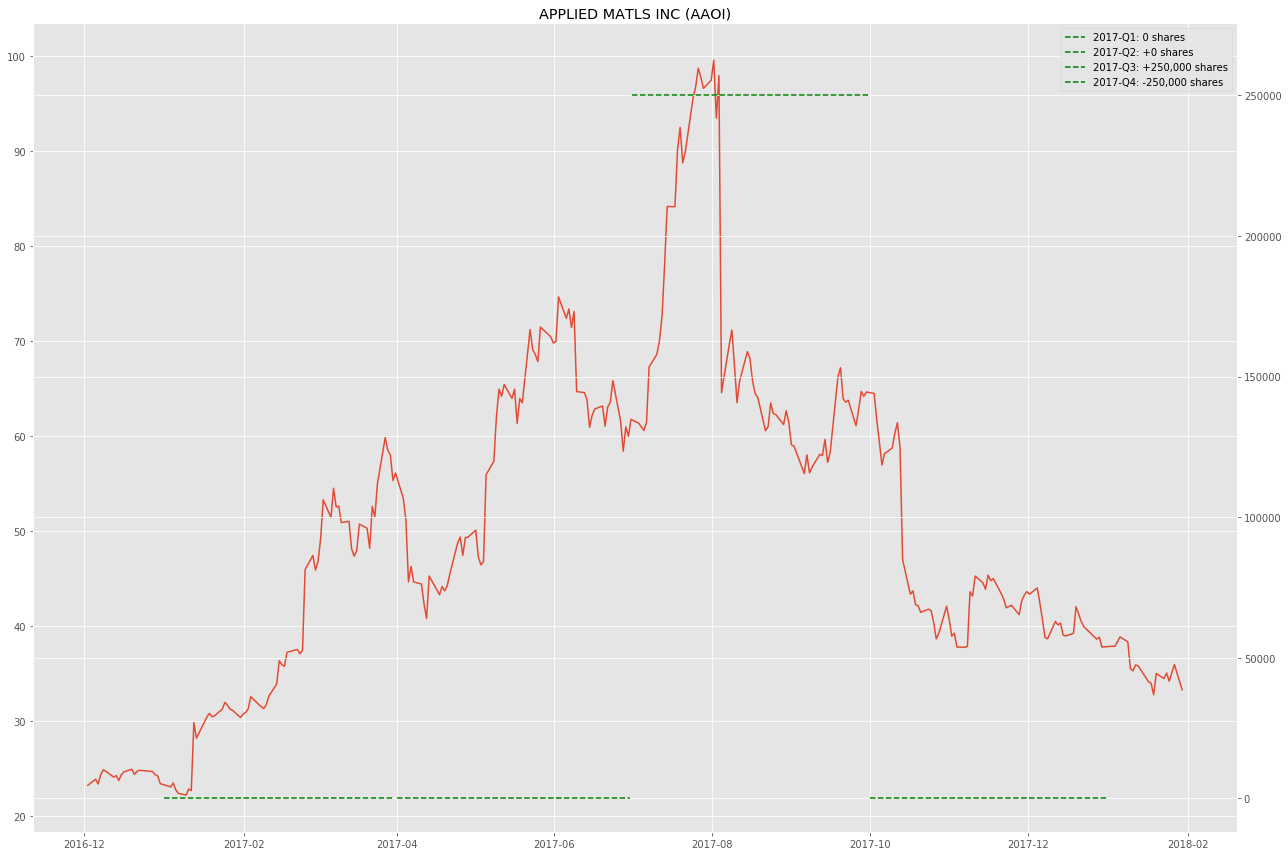

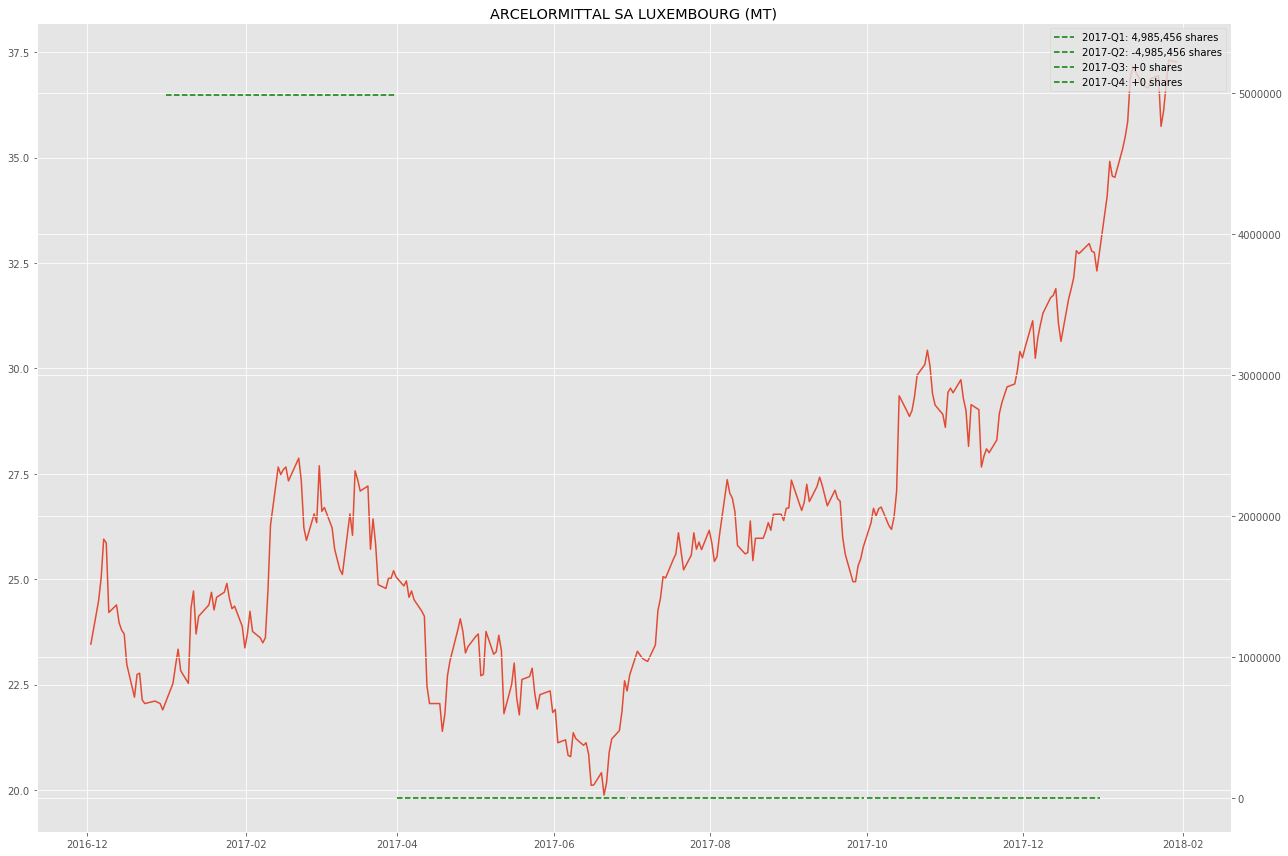

BAC$I {'chart': {'error': {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}, 'result': None}}


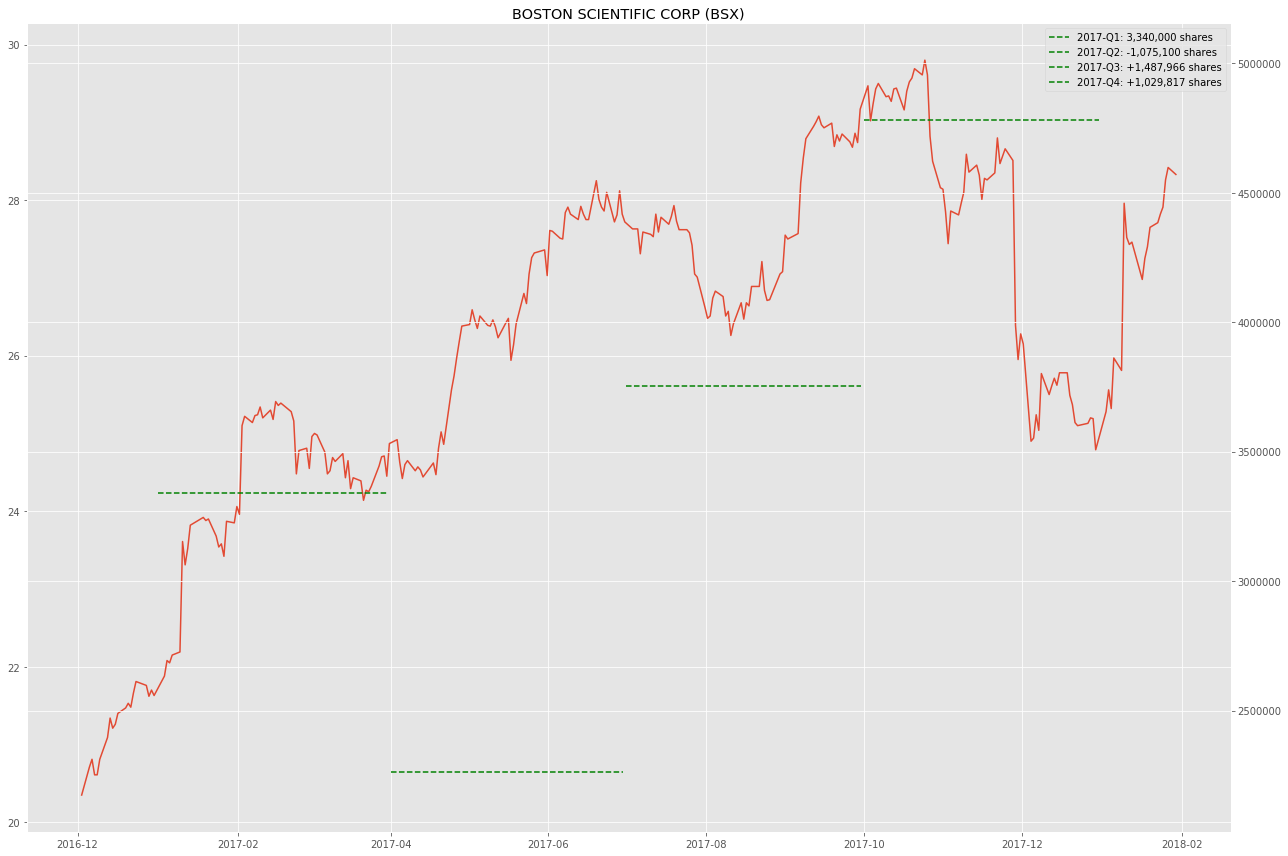

KeyboardInterrupt: 

In [10]:
for name in sorted(shares.Name.unique()):
    
    symbol = resolve_symbol(name)
    if symbol is None:
        print("Symbol is undefined for '{}'".format(name))
        continue
        
    all_dates_values = defaultdict(int)
    for row in shares[shares.Name == name].itertuples():
        start = datetime.strptime(row.Date, DATE_FM)
        all_dates_values[start] = int(row.Value) 
    
    shares_data = []
    prev_value = None
    for q_end in report_dates:
        value = all_dates_values[q_end]
        change = None if prev_value is None else value - prev_value
        prev_value = value
        q_start = q_end.replace(month=q_end.month - 2, day=1)
        shares_data.append(
            (q_start, q_end, value, change)
        )
    
    min_start = min(e[0] for e in shares_data)
    max_end = max(e[1] for e in shares_data)
    
    price_data = get_price_data(symbol, min_start - timedelta(days=30), max_end + timedelta(days=30))
    if price_data is None:
        continue
        
    plot_data("{} ({})".format(name, symbol), price_data, shares_data)